In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from scipy.spatial import KDTree

def loadPickle(path):
    with open(path, 'rb') as handle:
        return pickle.load(handle, encoding='latin1')

tess = loadPickle("data/pyramid/50K_pyr_narrow_tessellations.pkl")

generate_plots = True
generate_pyramid = True

In [2]:
def get_neighbours(triangulation):
    neighbours = [set() for _ in range(len(triangulation.points))]
    for t in triangulation.simplices:
        neighbours[t[0]].add(t[1])
        neighbours[t[0]].add(t[2])
        neighbours[t[1]].add(t[0])
        neighbours[t[1]].add(t[2])
        neighbours[t[2]].add(t[0])
        neighbours[t[2]].add(t[1])
    return neighbours

def calculate_neighborhood_size(triangulation):
    tessellation = triangulation.points
    
    size = np.zeros(len(tessellation), dtype='float64')
    tree = KDTree(tessellation)

    neighbours = get_neighbours(triangulation)
    num_neighbours = np.array([len(neighbours[i]) for i in range(len(neighbours))])
    num_neighbours += 1 # This is neccessary since the closest neighbour is always the point itself with a distance of 0
    
    for i in range(len(tessellation)):
        distance, index = tree.query(tessellation[i], k=num_neighbours[i])
        size[i] = np.mean(distance[1:])
    return size

def find_points_in_radius(tessellation, neighbours, node_index, distance, max_iter=10):
    points_to_check = neighbours[node_index].copy()
    points_in_raduis = set()
    found_new  = True
    i = 0
    d2 = distance*distance
    while found_new and i<max_iter:
        found_new = False
        for point in points_to_check:
            delta_x = tessellation[point][0]-tessellation[node_index][0]
            delta_y = tessellation[point][1]-tessellation[node_index][1]
            if (delta_x*delta_x)+(delta_y*delta_y) <= d2:
                found_new = True
                points_in_raduis.add(point)
        new_points = set()
        for point in points_to_check:
            new_points |= neighbours[point]
        new_points -= points_in_raduis
        points_to_check = new_points
        i+=1
    return points_in_raduis

def downsample(fine, coarse):
    tree = KDTree(fine)
    distance, index = tree.query(coarse)
    return (fine[index], index)

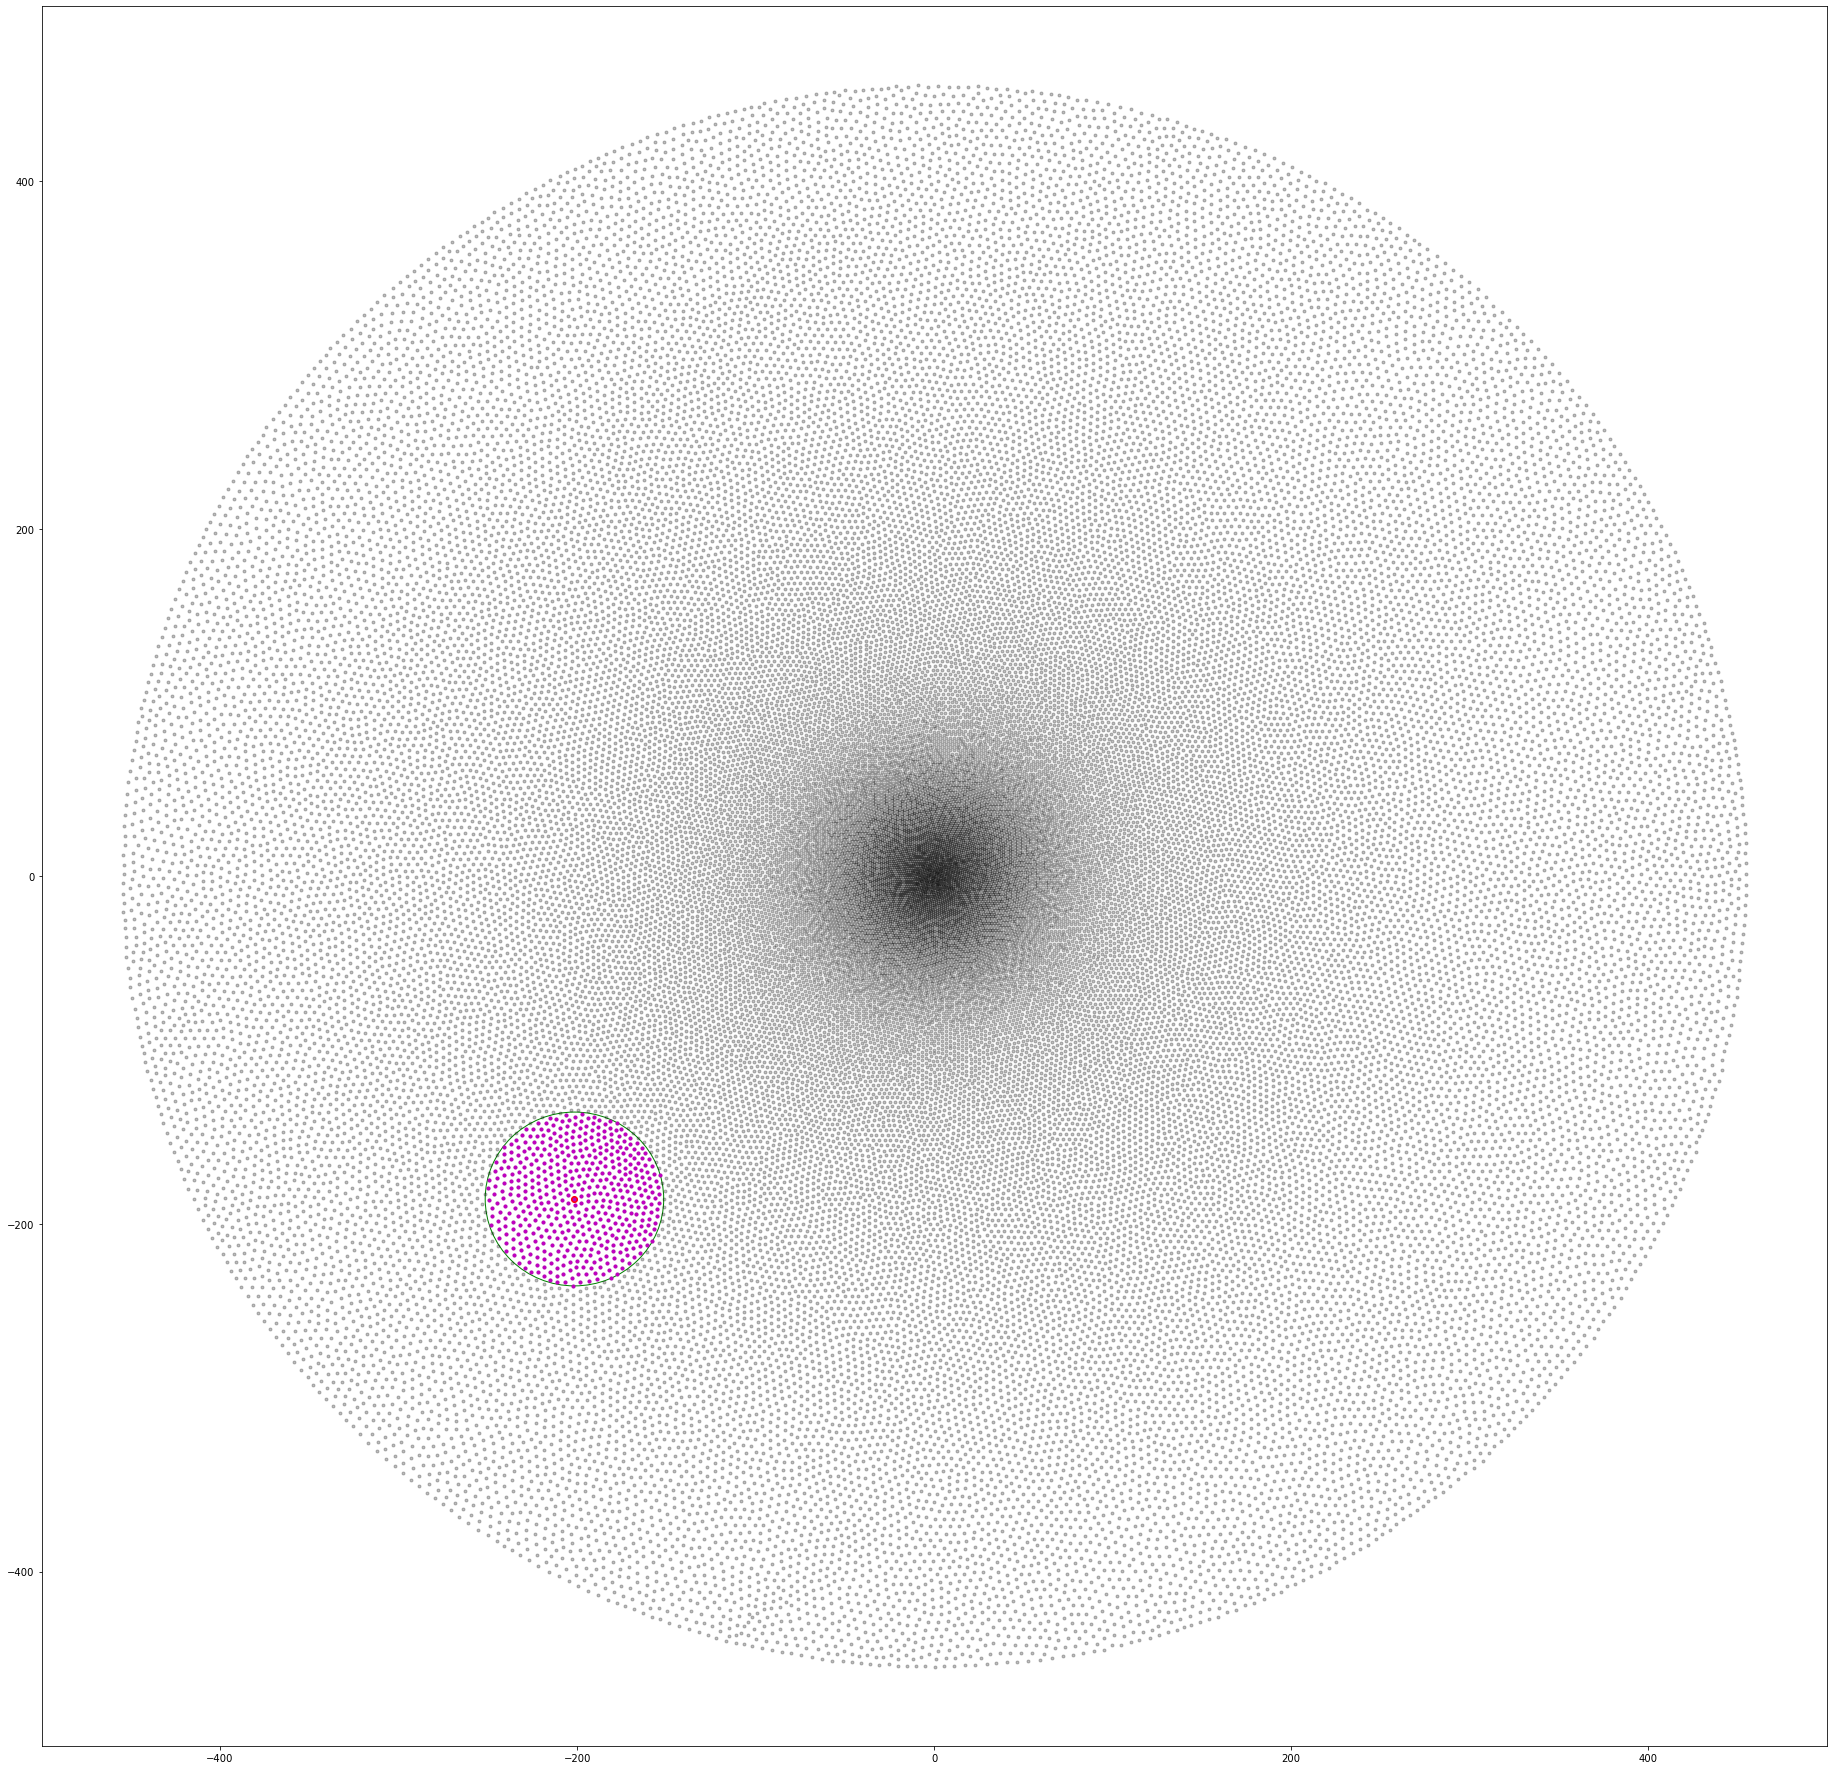

In [11]:
if generate_plots:
    level = 0
    node = 30000
    distance = 50

    tri = Delaunay(tess[level])
    neighbours = get_neighbours(tri)

    points = tess[level][list(find_points_in_radius(tess[level], neighbours, node, distance, 30))]

    plt.figure(figsize=(32,32))
    plt.plot(tess[level][:,0],tess[level][:,1], 'k.', alpha=0.25)
    plt.plot(tess[level][node,0],tess[level][node,1], 'ro')
    plt.plot(points[:,0],points[:,1], 'm.')
    ax = plt.gca()
    ax.add_patch(plt.Circle(tess[level][node], distance, color='g',fill=False))
    plt.show()

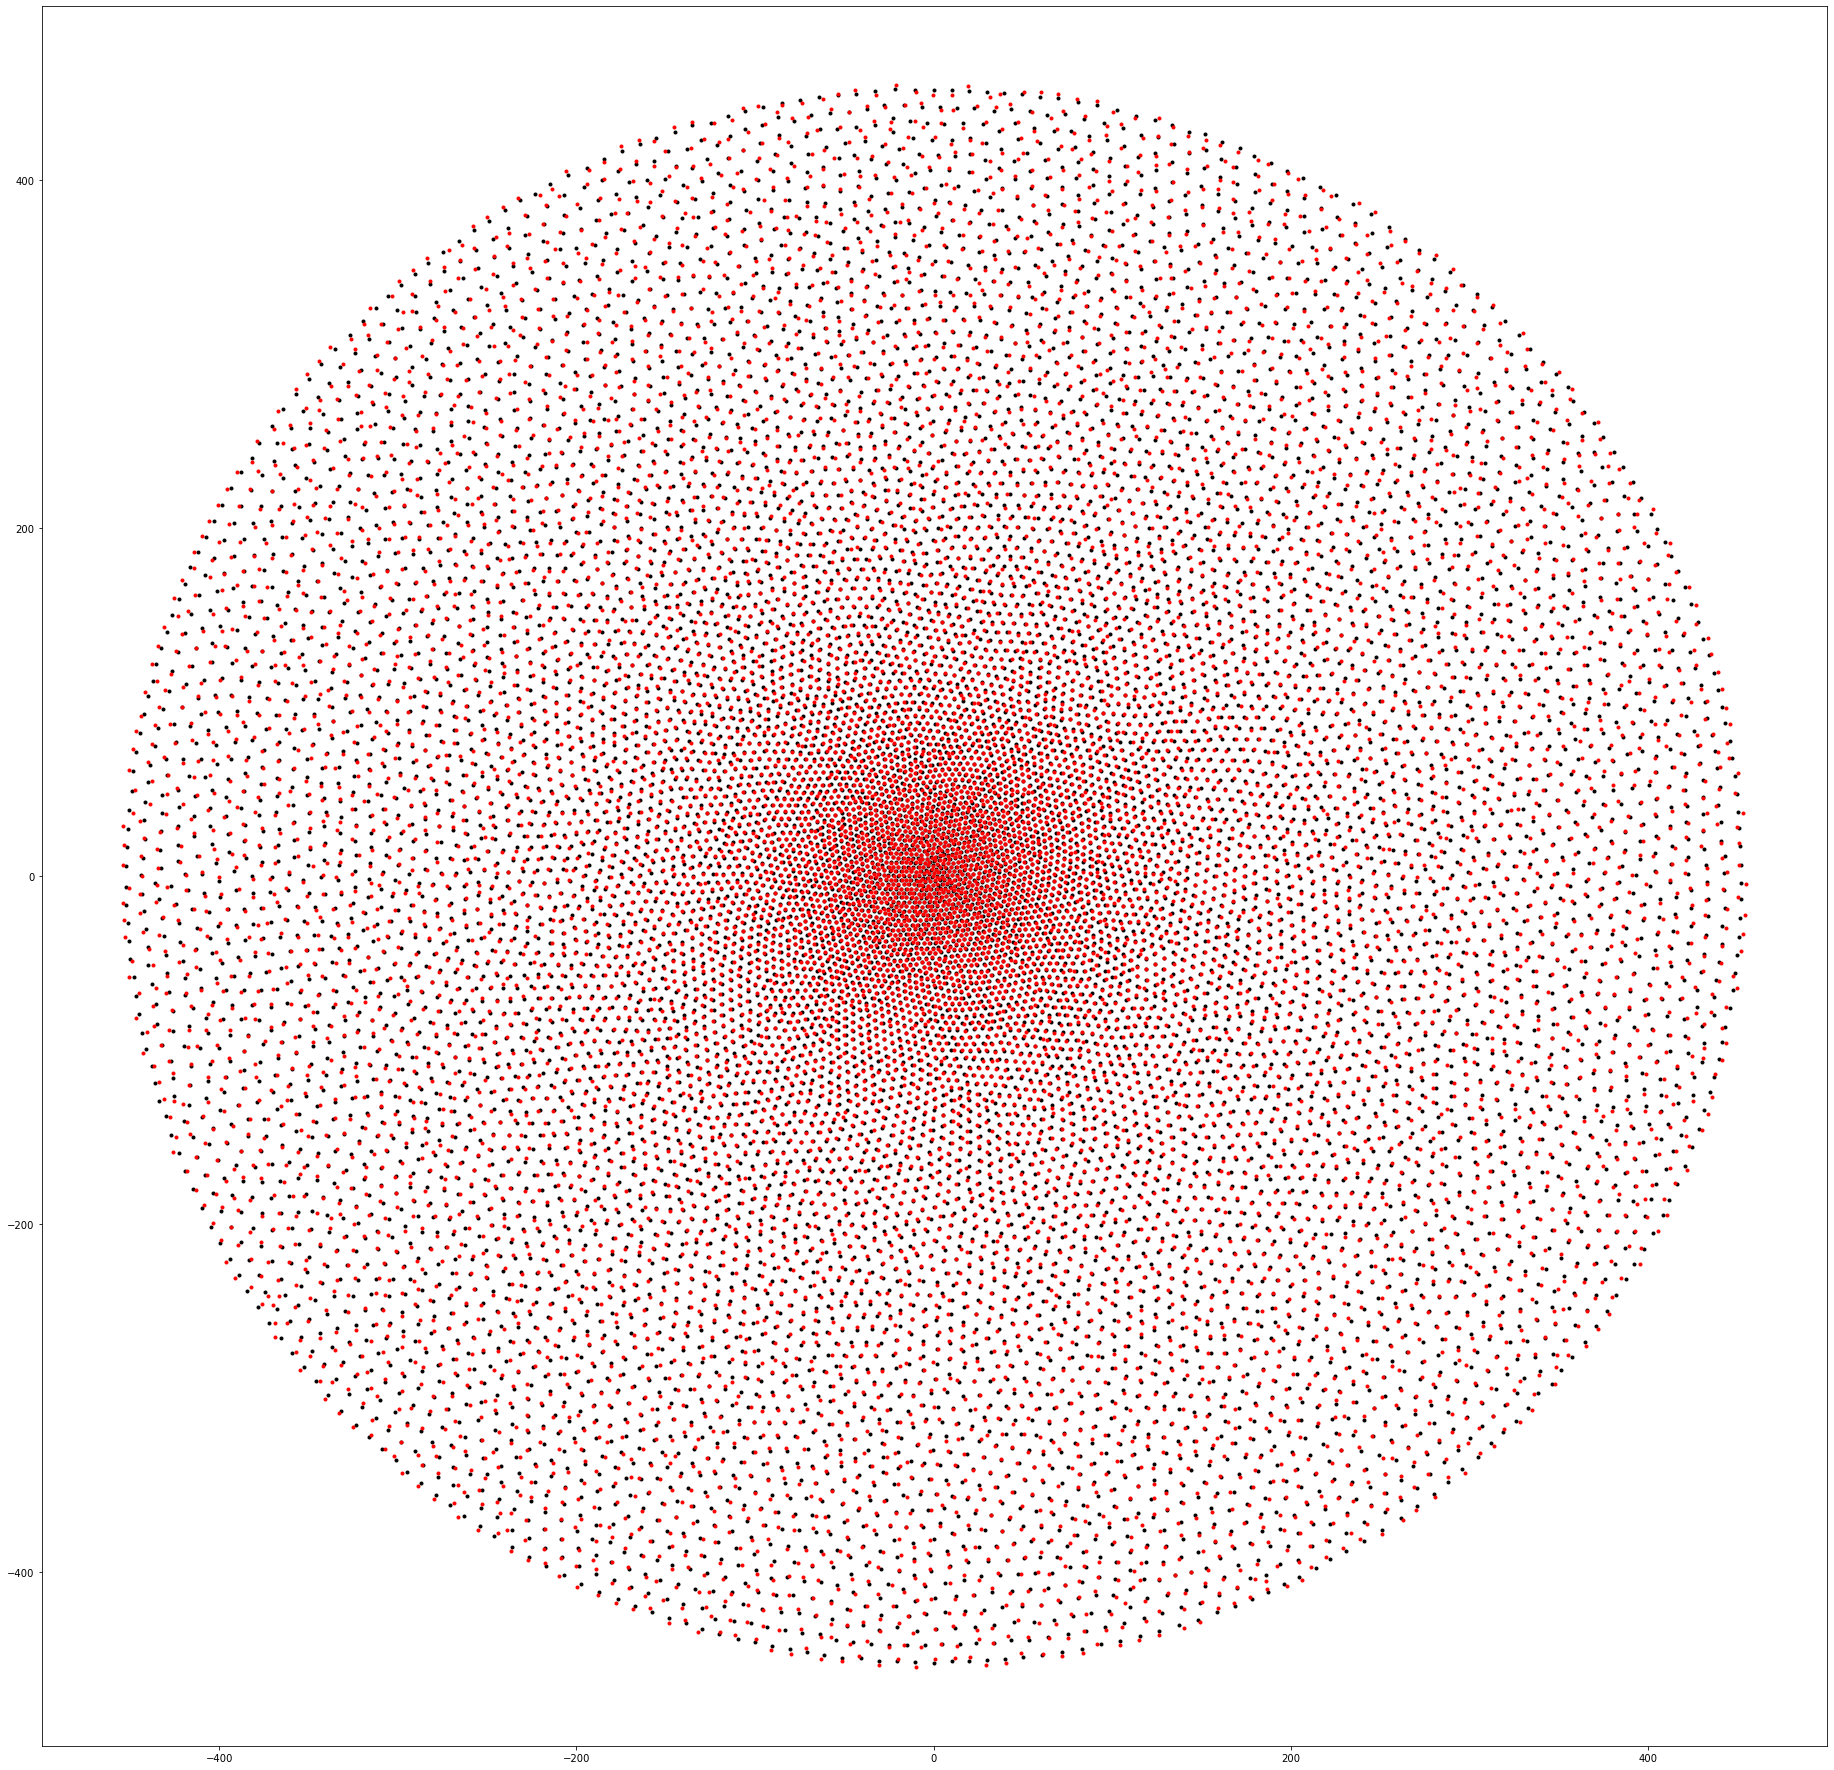

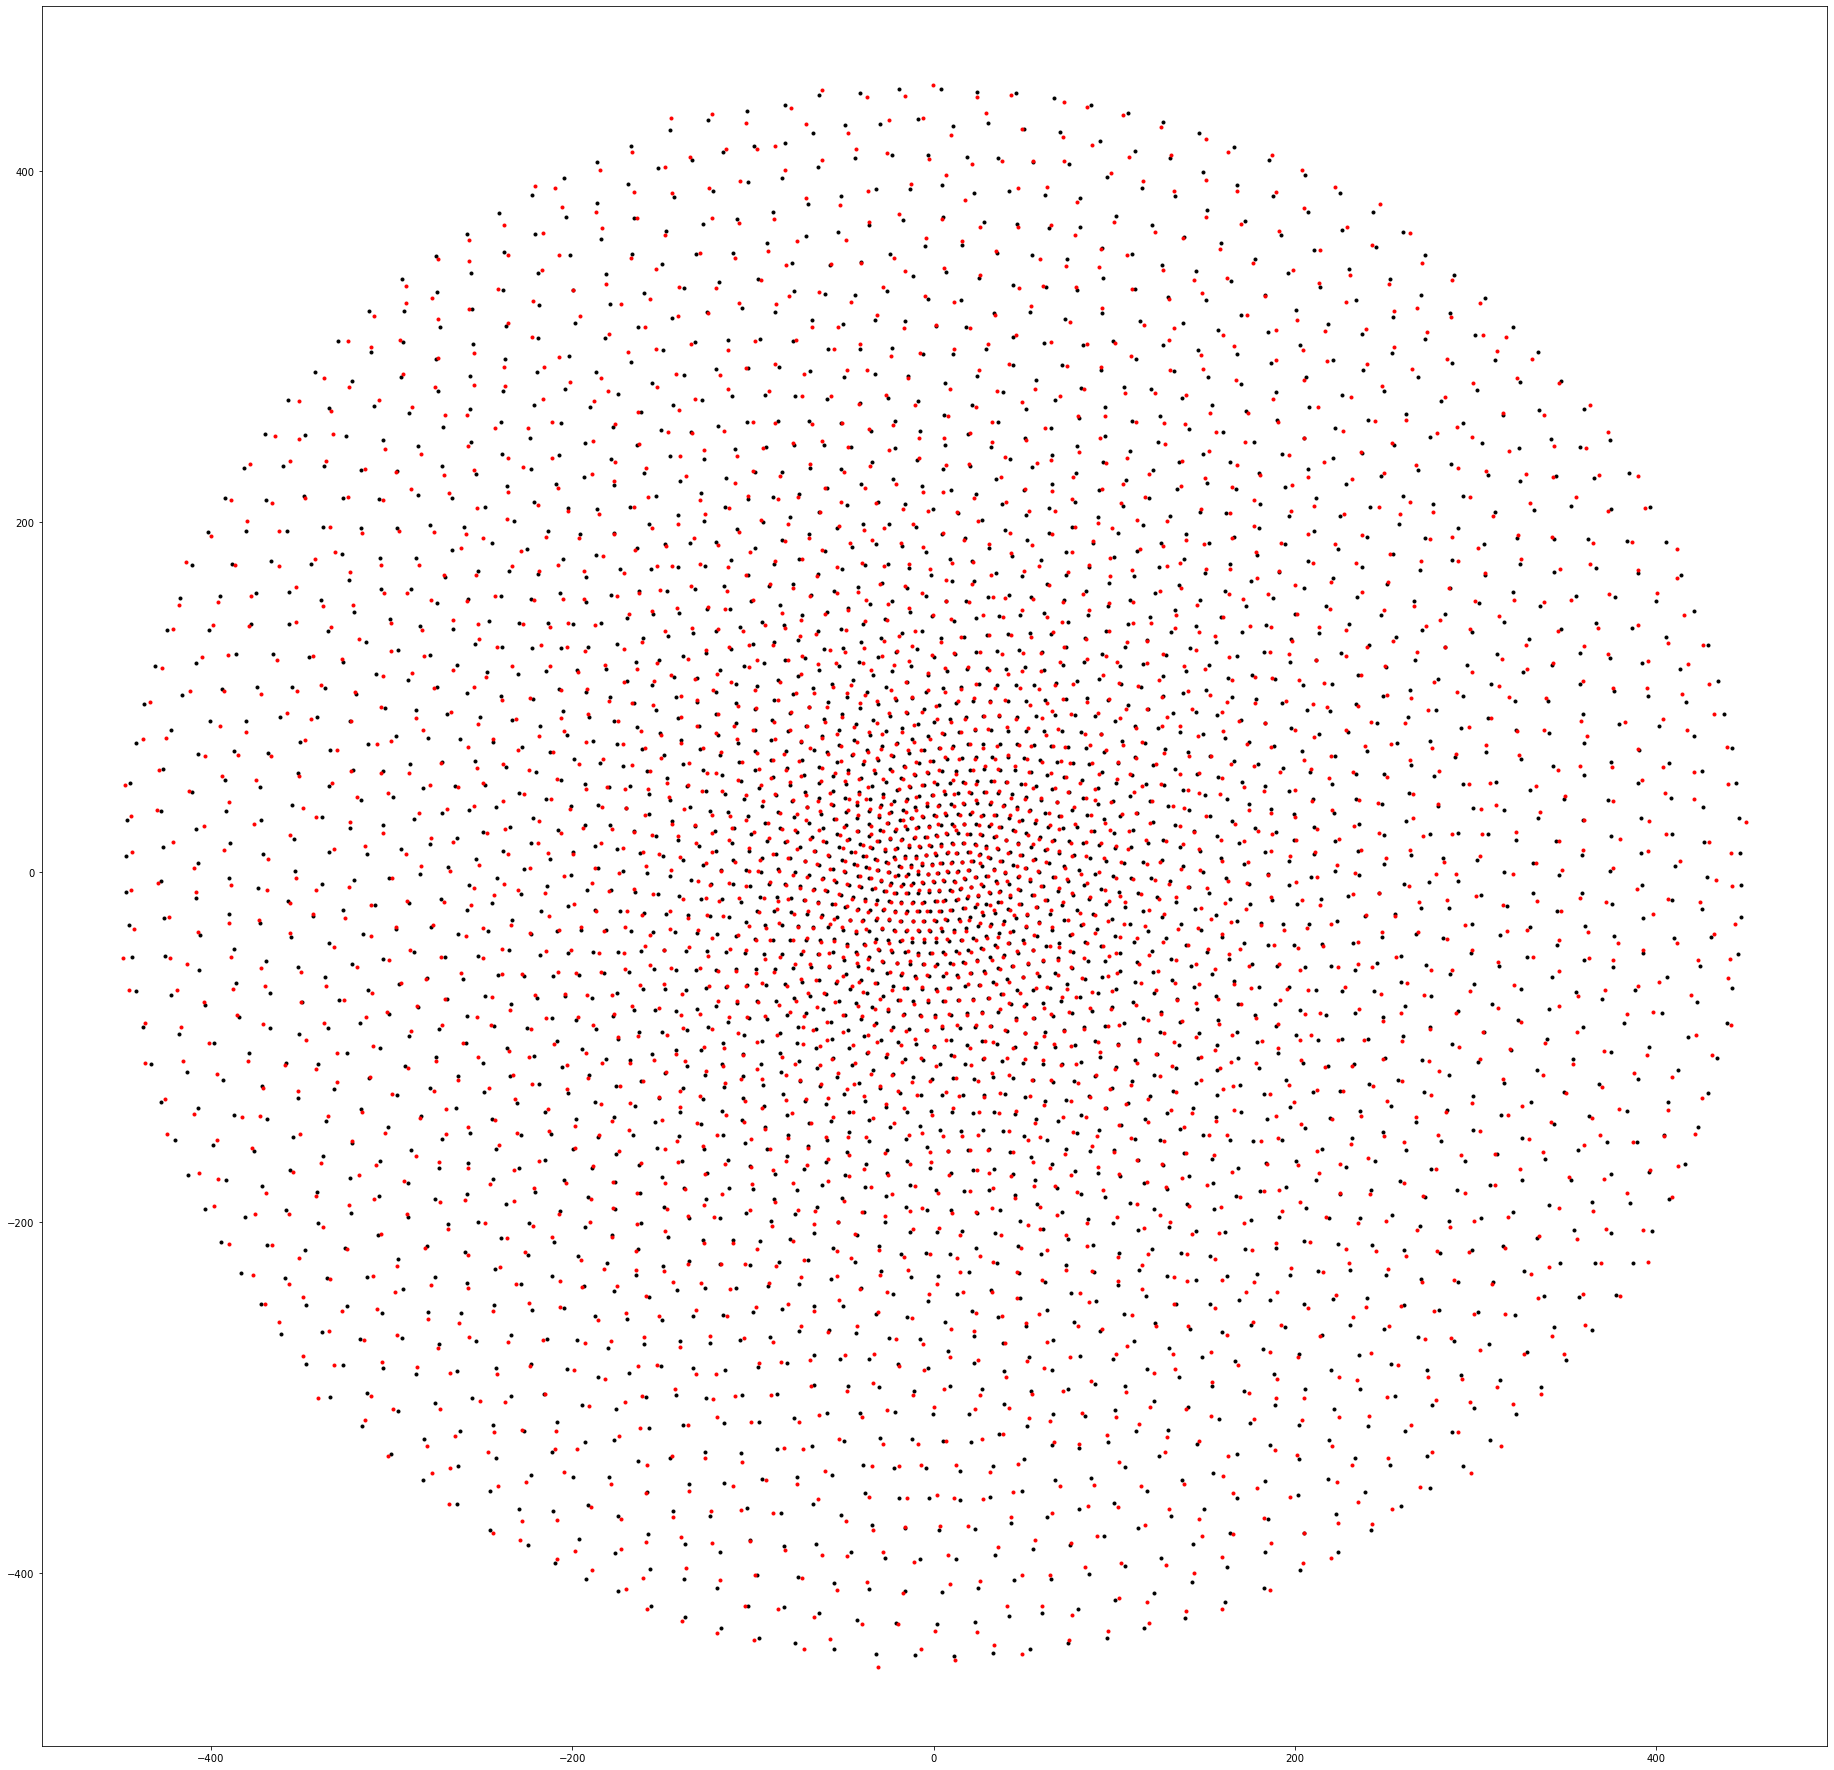

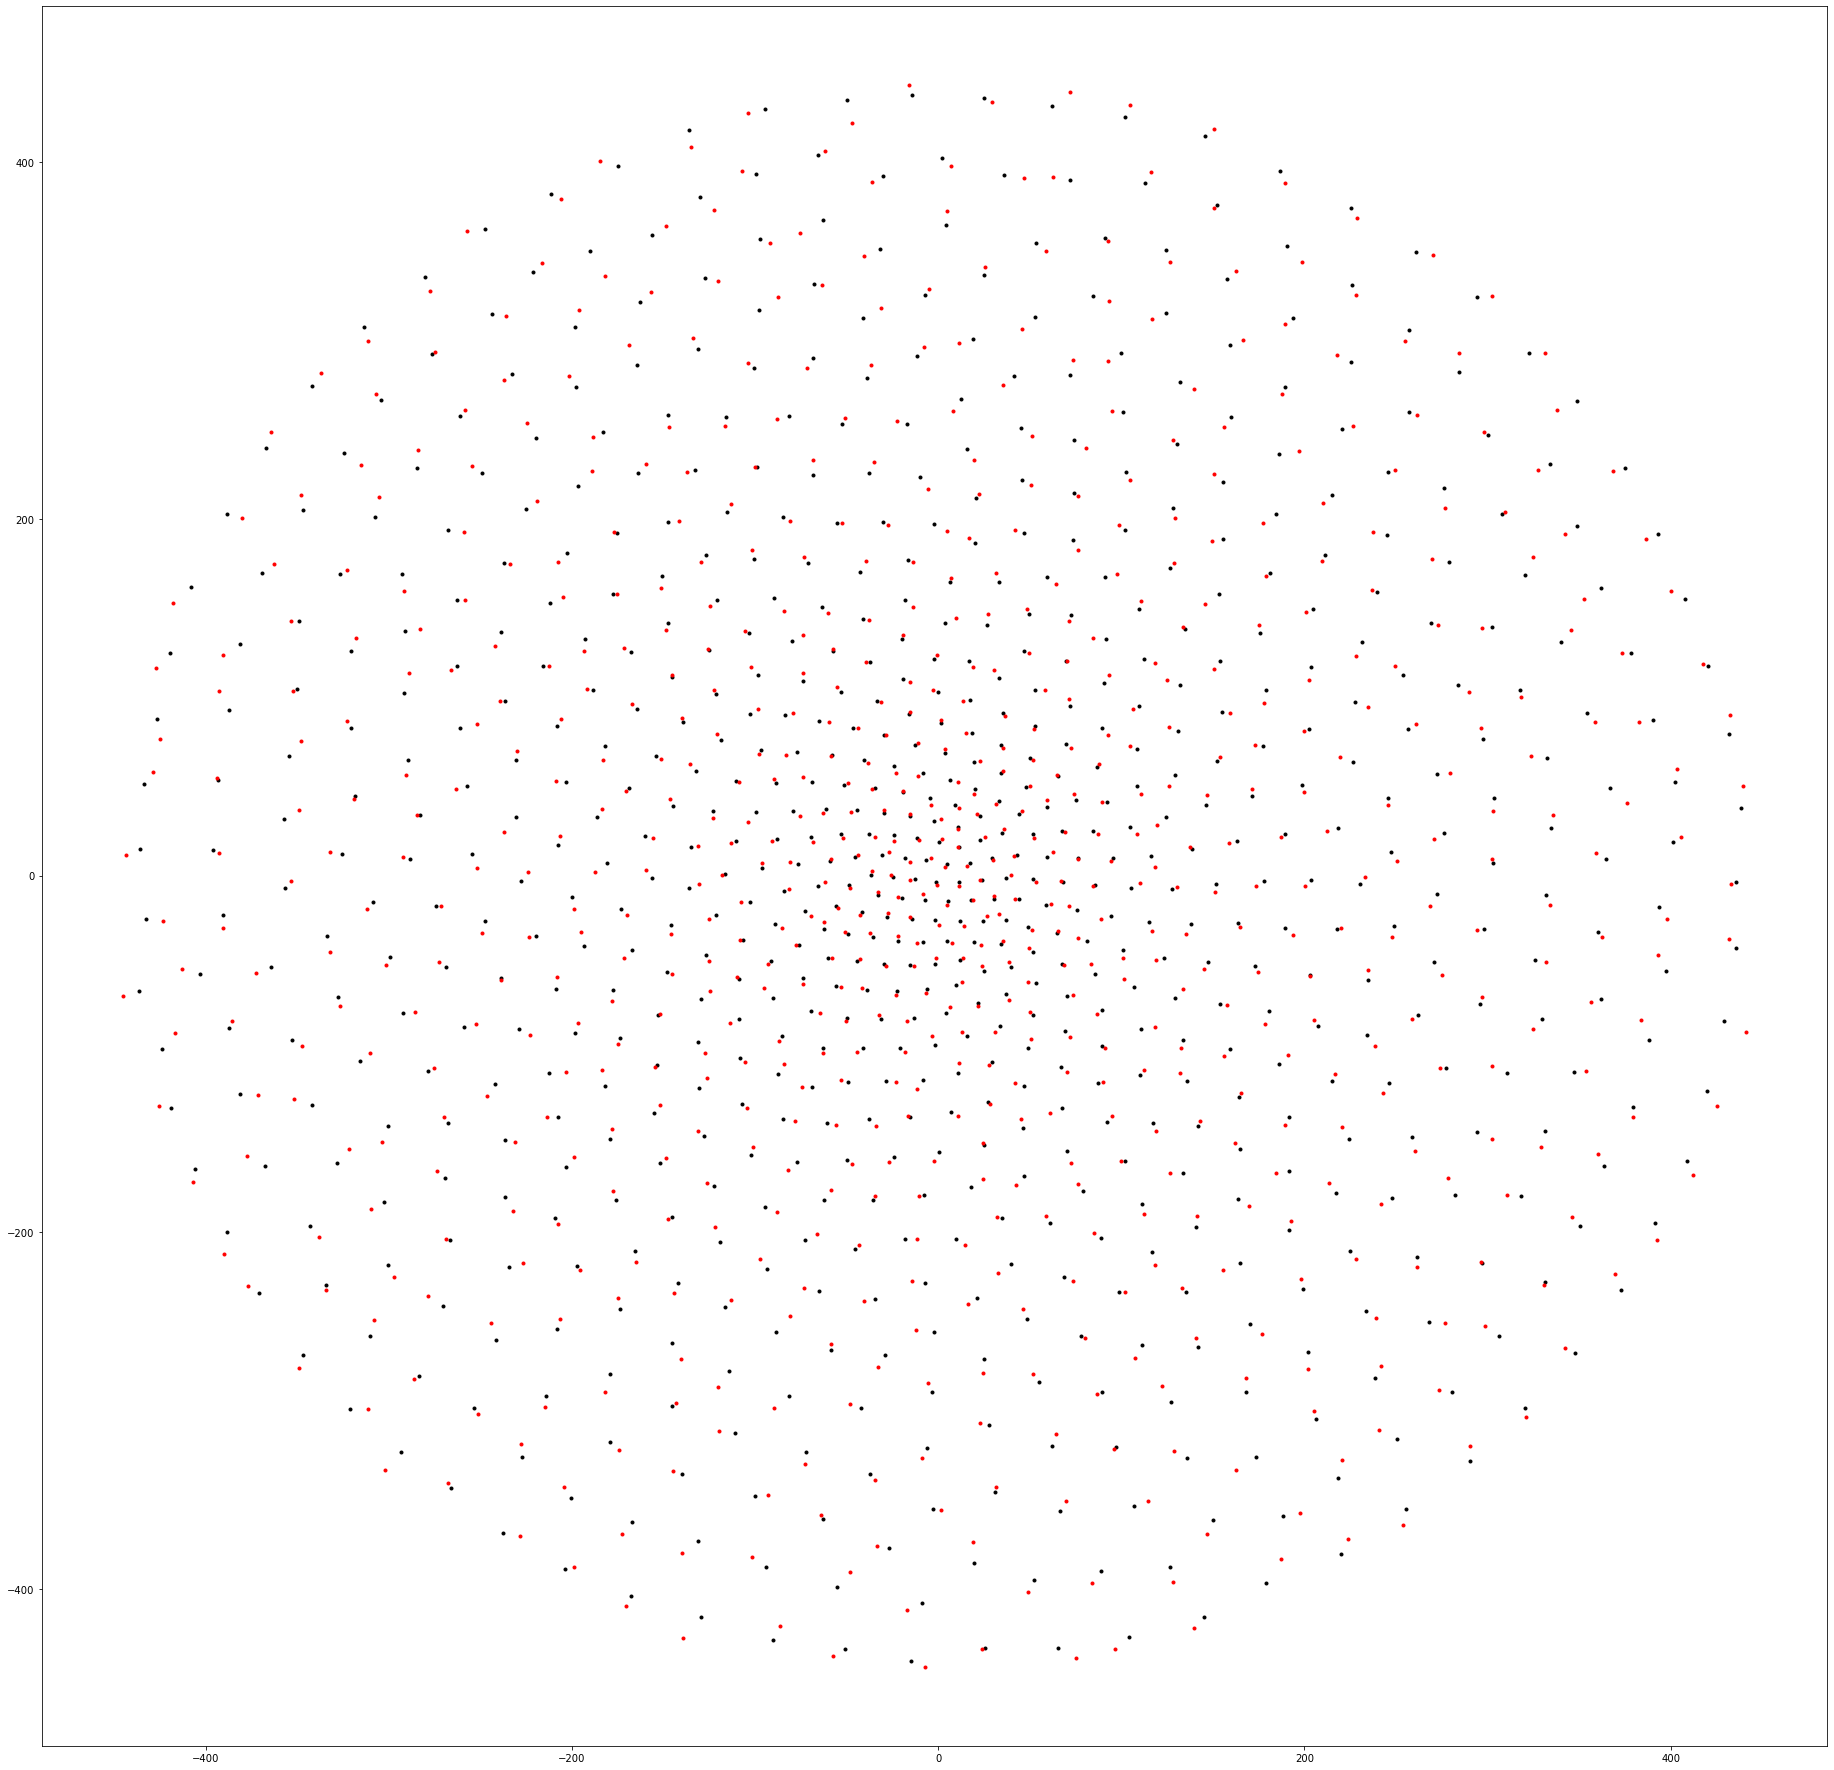

In [4]:
if generate_pyramid:
    alternative = [tess[0]]
    indices = []
    for level in range(1,len(tess)):
        points, index = downsample(alternative[level-1], tess[level])
        alternative.append(points)
        indices.append(index)

if generate_plots:
    for level in range(1,len(tess)):
        plt.figure(figsize=(32,32))
        plt.plot(tess[level][:,0],tess[level][:,1], 'k.')
        plt.plot(alternative[level][:,0],alternative[level][:,1], 'r.')
        plt.show()

In [5]:
if generate_pyramid:
    scaling_factor=1
    support_region_ratio=3

    pyr = []

    fine = Delaunay(alternative[0])
    fine_neighbors = get_neighbours(fine)

    for level in range(1,len(alternative)):
        index_array = []
        coeff_array = []
        size_array = []

        coarse = Delaunay(alternative[level])
        coarse_neighbors = get_neighbours(coarse)
        tessellation = fine.points

        sigma = calculate_neighborhood_size(coarse) * scaling_factor
        max_distance = sigma * support_region_ratio

        sigma *= sigma
        sigma *= 2

        for i in range(len(coarse.points)):
            points_in_radius = list(find_points_in_radius(tessellation, fine_neighbors, indices[level-1][i], max_distance[i]))
            coords = tessellation[points_in_radius]
            coords -= coarse.points[i]
            coords *= coords
            coords /= sigma[i]
            coeffs = np.exp(-(coords[:,0] + coords[:,1]))
            coeffs /= coeffs.sum()

            index_array+=(points_in_radius)
            coeff_array+=list(coeffs)
            size_array.append(len(points_in_radius))

        index_array=np.array(index_array)
        coeff_array=np.array(coeff_array)
        size_array=np.array(size_array)

        pyr.append((index_array,coeff_array,size_array,len(tessellation)))

        fine = coarse
        fine_neighbors = coarse_neighbors

In [6]:
if generate_pyramid:
    with open('Pyramid_Arrays.pkl', 'wb') as f:
        pickle.dump(pyr, f)

In [7]:
if generate_plots:
    scaling_factor=1
    support_region_ratio=3

    pyr_inspection = []

    fine = Delaunay(alternative[0])
    fine_neighbors = get_neighbours(fine)

    for level in range(1,len(alternative)):
        output = []

        coarse = Delaunay(alternative[level])
        coarse_neighbors = get_neighbours(coarse)
        tessellation = fine.points

        sigma = calculate_neighborhood_size(coarse) * scaling_factor
        max_distance = sigma * support_region_ratio

        sigma *= sigma
        sigma *= 2

        for i in range(len(coarse.points)):
            points_in_radius = list(find_points_in_radius(tessellation, fine_neighbors, indices[level-1][i], max_distance[i]))
            coords = tessellation[points_in_radius]
            coords -= coarse.points[i]
            coords *= coords
            coords /= sigma[i]
            coeffs = np.exp(-(coords[:,0] + coords[:,1]))
            coeffs /= coeffs.sum()

            output.append((points_in_radius, coeffs, max_distance[i]))

        pyr_inspection.append(output)

        fine = coarse
        fine_neighbors = coarse_neighbors

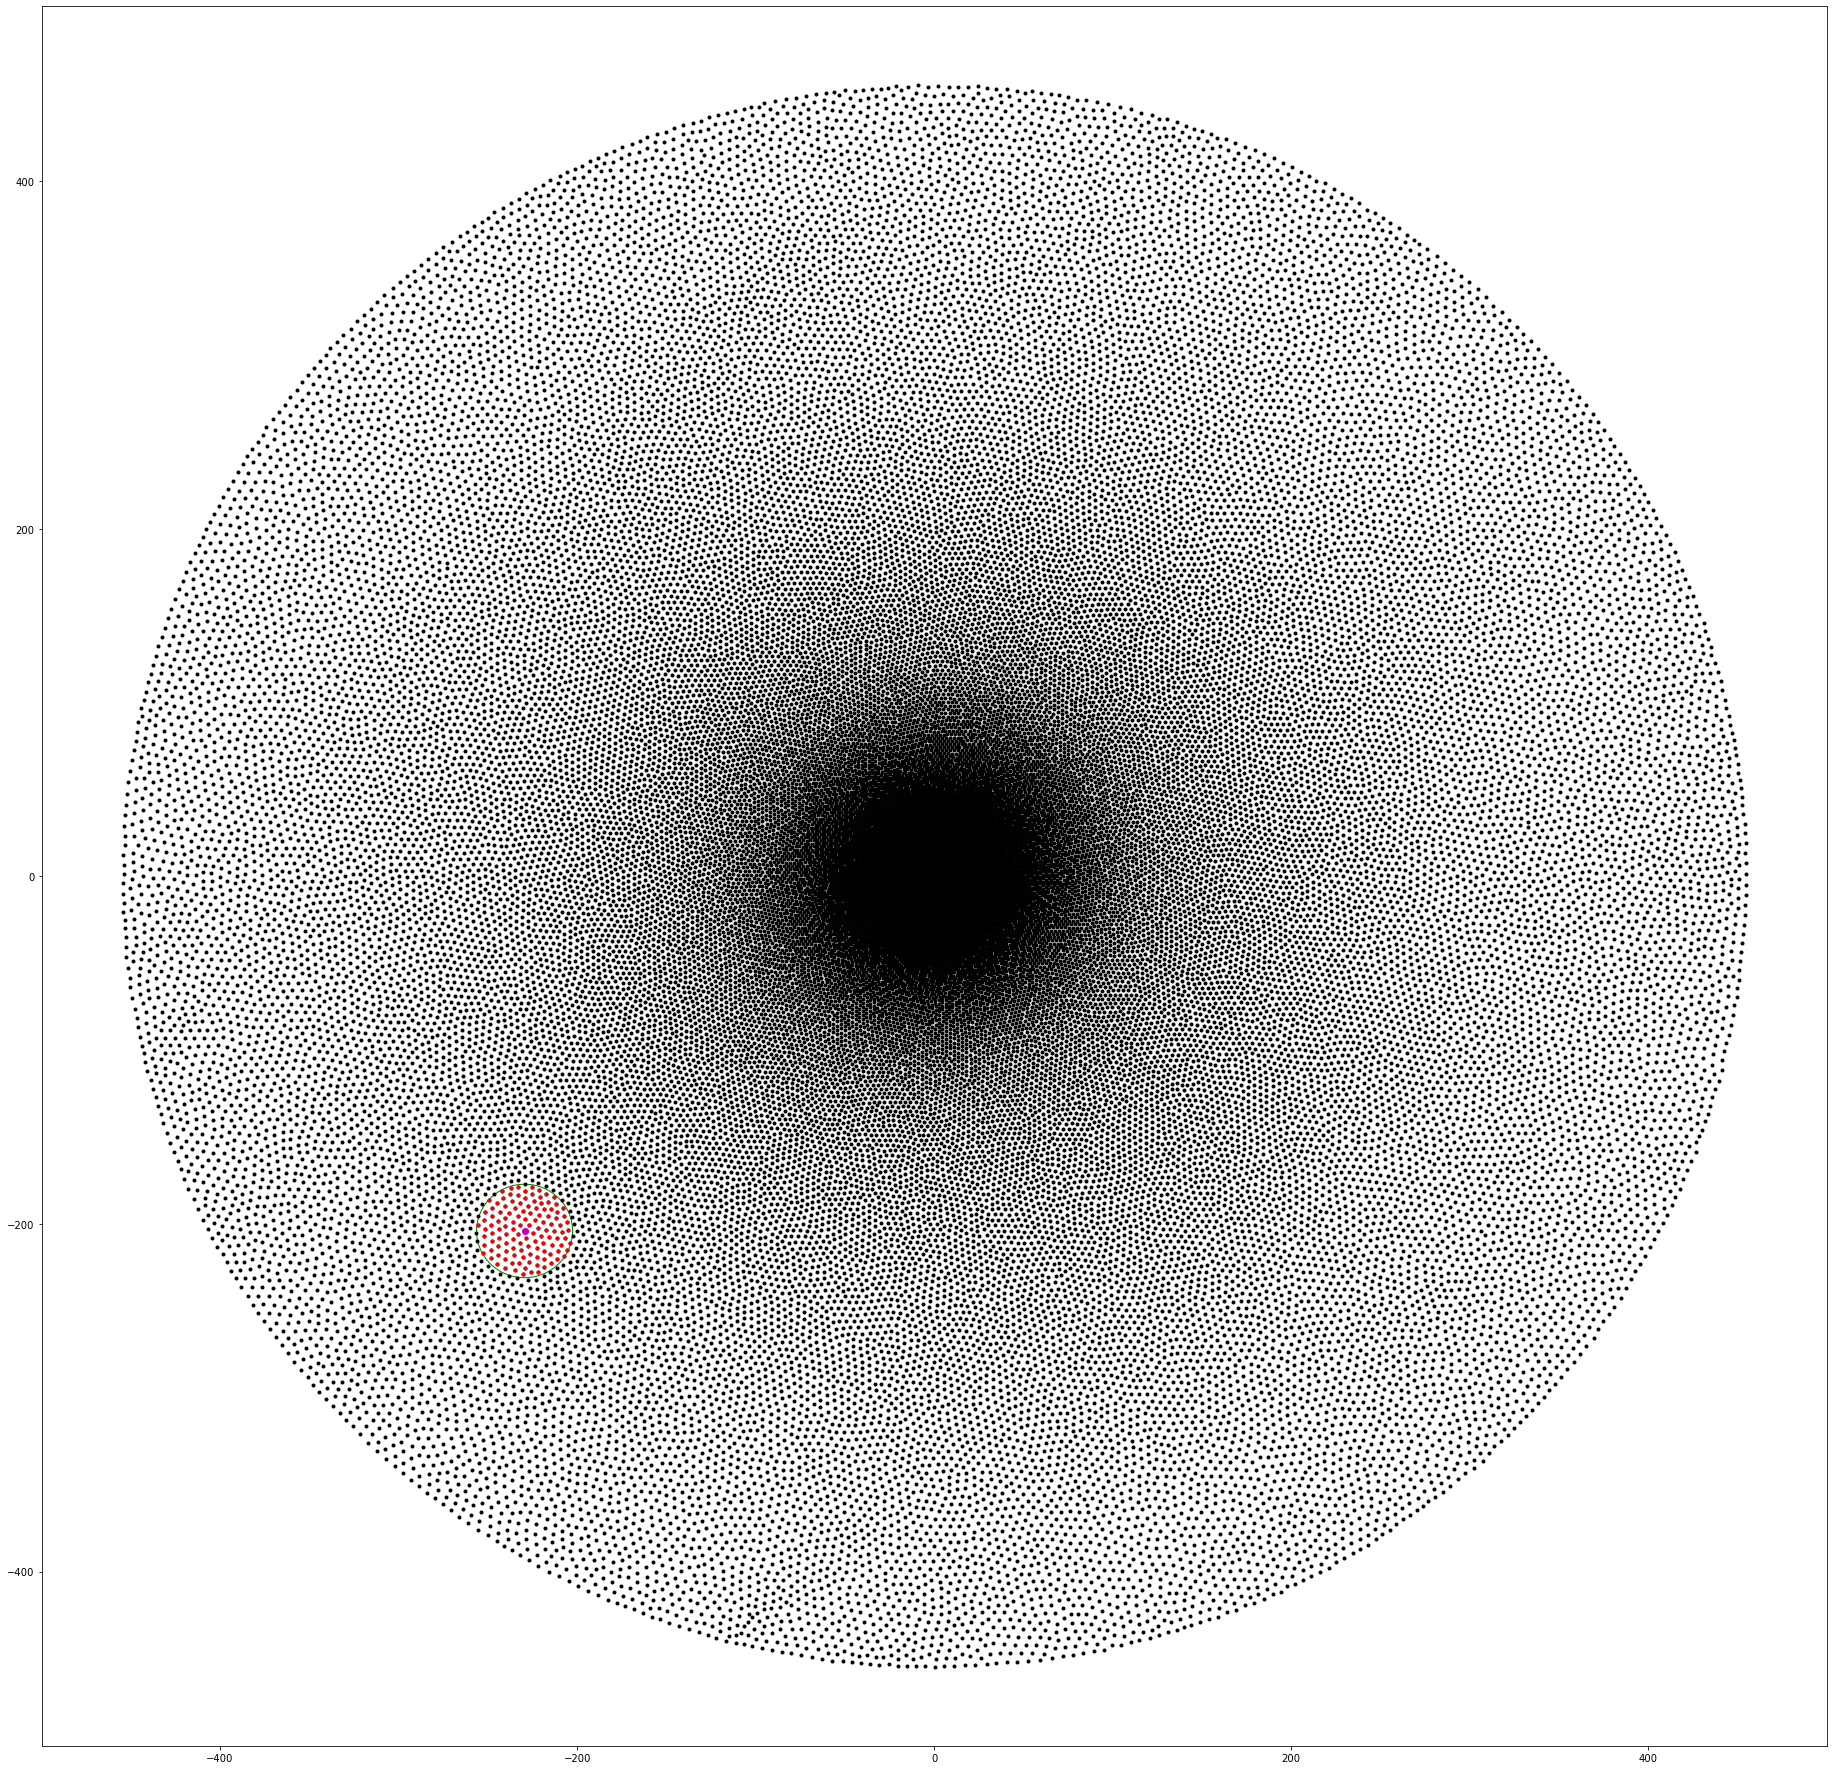

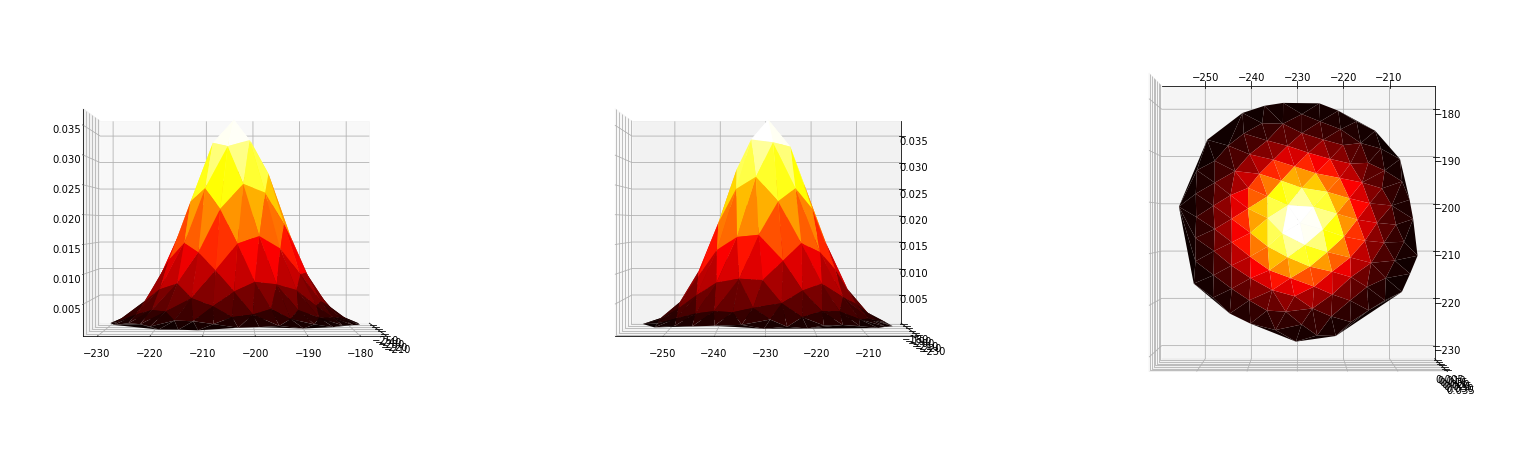

In [14]:
if generate_plots:
    level = 0
    node = 2000
    idx = pyr_inspection[level][node][0]
    coeff = pyr_inspection[level][node][1]
    distance = pyr_inspection[level][node][2]
    locs = alternative[level][idx]

    plt.figure(figsize=(32,32))
    plt.plot(alternative[level][:,0],alternative[level][:,1], 'k.')
    plt.plot(locs[:,0],locs[:,1], 'r.')
    plt.plot(alternative[level+1][node,0],alternative[level+1][node,1], 'mo')
    ax = plt.gca()
    ax.add_patch(plt.Circle(alternative[level+1][node], distance, color='g',fill=False))
    plt.show()

    fig = plt.figure(figsize=(27,9))
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    ax2 = fig.add_subplot(1, 3, 2, projection='3d')
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ax1.plot_trisurf(locs[:,0],locs[:,1],coeff, cmap='hot')
    ax1.view_init(0, 0)
    ax2.plot_trisurf(locs[:,0],locs[:,1],coeff, cmap='hot')
    ax2.view_init(0, 270)
    ax3.plot_trisurf(locs[:,0],locs[:,1],coeff, cmap='hot')
    ax3.view_init(90, 270)
    plt.show()